In [1]:
# Data Management/Investigation
import pandas as pd
from pandas.api.types import CategoricalDtype # Ordering categories
import numpy as np
import missingno as miss

# Plotting libraries
from plotnine import *
import matplotlib.backend_bases
import matplotlib.pyplot as plt
import seaborn as sns

# For pre-processing data 
from sklearn import preprocessing as pp 
from sklearn.compose import ColumnTransformer 
from sklearn.compose import make_column_selector

# For splits and CV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold # Cross validation 
from sklearn.model_selection import cross_validate # Cross validation 
from sklearn.model_selection import GridSearchCV # Cross validation + param. tuning.

# Machine learning methods 
from sklearn.linear_model import LinearRegression as LM
from sklearn.neighbors import KNeighborsRegressor as KNN
from sklearn.tree import DecisionTreeRegressor as DTree
from sklearn import tree # For plotting the decision tree rules
from sklearn.ensemble import BaggingRegressor as Bag # for bagging
from sklearn.ensemble import RandomForestRegressor as RF

# For evaluating our model's performance
import sklearn.metrics as m

# Pipeline to combine modeling elements
from sklearn.pipeline import Pipeline

# Model interpretation
from sklearn.inspection import partial_dependence
from sklearn.inspection import plot_partial_dependence
from sklearn.inspection import permutation_importance
import eli5 # "explain it to me like I'm 5"
from eli5.sklearn import PermutationImportance

#eda
import pandas_profiling

# Misc
import warnings
warnings.filterwarnings("ignore")

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.


## Explore data: all year NONA net metering

In [2]:
df_nm = pd.read_csv("./processed_data/df_nm.csv")

In [3]:
df_nm.dtypes

year            float64
name             object
state            object
total_mwh       float64
total_cust      float64
no              float64
type             object
saidi_nomed     float64
saifi_nomed      object
caidi_nomed      object
circuits        float64
voltage         float64
nerc             object
gen_mwh          object
purchase_mwh     object
pv_mwh          float64
wind_mwh        float64
nm_mwh          float64
pv_pct          float64
wind_pct        float64
nm_pct          float64
circuit_pct     float64
dtype: object

In [4]:
# convert object variables to categories
for col in df_nm.select_dtypes(include="object"):
    df_nm[col] = df_nm[col].astype('category')

In [5]:
df_nm.shape

(2960, 22)

## Outcomes I wanna use: 
- Control: Type, State, NERC, total MWH, Voltage
- NM pct, EE pct, Dem res customer pct

In [9]:
y = df_nm['saidi_nomed']
X = df_nm[['state','type','total_mwh',
           'nerc','nm_pct','circuit_pct']]

In [10]:
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size=.25,random_state=1997)

In [11]:
print(train_X.shape[0]/df_nm.shape[0])
print(test_X.shape[0]/df_nm.shape[0])

0.75
0.25


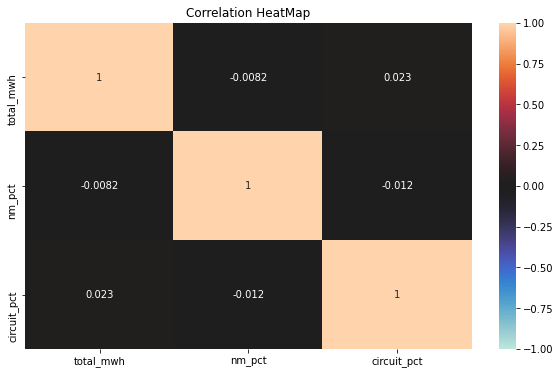

In [12]:
#creating pairwise correlation of columns using Pearson's R,
corr = train_X.corr(method='pearson') 

#plotting the correlation coefficients on a seasborn heatmap matrix
fig, ax = plt.subplots(figsize=(10,6))
sns.heatmap(corr, annot=True, 
            vmin = -1, vmax=1, center=0)

plt.title('Correlation HeatMap')
plt.show()

### Remove either circuits or total mwh

In [13]:
df_nm.skew().sort_values(ascending = False)

pv_pct         39.842050
nm_pct         39.701631
wind_pct       38.538543
wind_mwh       30.337343
saidi_nomed    17.223840
pv_mwh         15.098132
nm_mwh         14.887632
voltage         7.438128
total_cust      6.142105
total_mwh       5.604040
circuits        4.993263
no              1.530681
circuit_pct     1.358912
year           -0.173001
dtype: float64

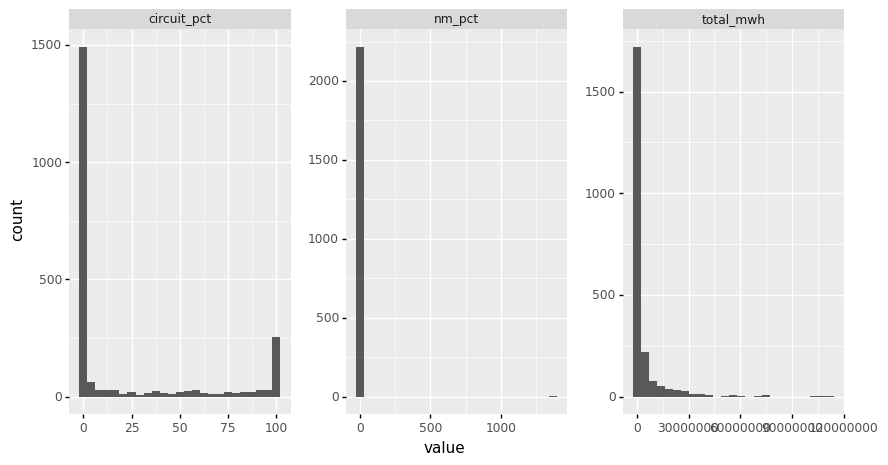

<ggplot: (8777220440145)>

In [14]:
# Plot the continuous variables 
df_num = train_X.select_dtypes(include="number").melt()

(
    ggplot(df_num,aes(x="value")) +
    geom_histogram(bins=25) +
    facet_wrap("variable",scales='free') +
    theme(figure_size=(10,5),
          subplots_adjust={'wspace':0.25})
)

## Transform the features and outcome

In [15]:
df_nm_log = df_nm.copy()

# log some variables
df_nm_log['total_mwh'] = np.log(df_nm_log['total_mwh'])
df_nm_log['circuit_pct'] = np.log(df_nm_log['circuit_pct'] + 1)

# nm percent 
median_nm_pct = df_nm.loc[df_nm_log['nm_pct'] > 0,'nm_pct'].median()
df_nm_log['nm_pct'] =  np.where(df_nm_log['nm_pct']==0,0,np.where(df_nm_log['nm_pct'] <= median_nm_pct,1,2))

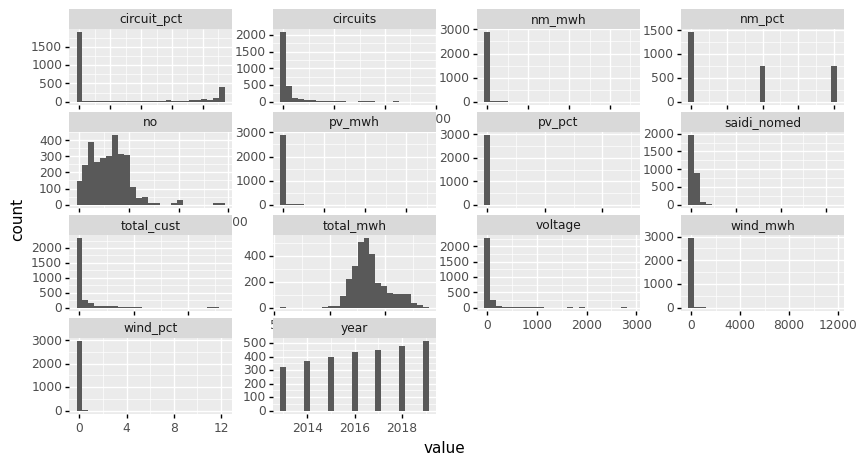

<ggplot: (8777199767589)>

In [16]:
# Plot the continuous variables 
df_nm_num = df_nm_log.select_dtypes(include="number").melt()

(
    ggplot(df_nm_num,aes(x="value")) +
    geom_histogram(bins=25) +
    facet_wrap("variable",scales='free') +
    theme(figure_size=(10,5),
          subplots_adjust={'wspace':0.25})
)

### Let's dummify NERC regions, state, and utility type

In [17]:
nerc_dummies = pd.get_dummies(df_nm_log.nerc)

In [18]:
# we'll use FRCC as our reference category
nerc_dummies = nerc_dummies.drop(['FRCC'],axis=1)
nerc_dummies.head()

,AK,ECAR,HI,MISO,MRO,NPCC,RFC,SERC,SPP,TRE,WECC,serc
0,0,0,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,0,0


In [19]:
df_nm_log = pd.concat([df_nm_log.drop(['nerc'],axis=1),nerc_dummies],axis=1)

In [20]:
type_dummies = pd.get_dummies(df_nm_log.type)

In [21]:
# we'll use State as our reference category
type_dummies = type_dummies.drop(['State'],axis=1)
type_dummies.head()

,Cooperative,Investor Owned,Municipal,Political Subdivision
0,1,0,0,0
1,1,0,0,0
2,1,0,0,0
3,1,0,0,0
4,1,0,0,0


In [22]:
df_nm_log = pd.concat([df_nm_log.drop(['type'],axis=1),type_dummies],axis=1)

In [23]:
state_dummies = pd.get_dummies(df_nm_log.state)

In [24]:
state_dummies

,AK,AL,AR,AZ,CA,CO,CT,DC,DE,FL,...,SC,SD,TX,UT,VA,VT,WA,WI,WV,WY
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2955,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2956,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2957,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2958,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
# we'll use AR as our reference category
state_dummies = state_dummies.drop(['AR'],axis=1)
state_dummies.head()

,AK,AL,AZ,CA,CO,CT,DC,DE,FL,GA,...,SC,SD,TX,UT,VA,VT,WA,WI,WV,WY
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
df_nm_log = pd.concat([df_nm_log.drop(['state'],axis=1),state_dummies],axis=1)

In [27]:
df_nm_log.columns

Index(['year', 'name', 'total_mwh', 'total_cust', 'no', 'saidi_nomed',
       'saifi_nomed', 'caidi_nomed', 'circuits', 'voltage', 'gen_mwh',
       'purchase_mwh', 'pv_mwh', 'wind_mwh', 'nm_mwh', 'pv_pct', 'wind_pct',
       'nm_pct', 'circuit_pct', 'AK', 'ECAR', 'HI', 'MISO', 'MRO', 'NPCC',
       'RFC', 'SERC', 'SPP', 'TRE', 'WECC', 'serc', 'Cooperative',
       'Investor Owned', 'Municipal', 'Political Subdivision', 'AK', 'AL',
       'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'HI', 'IA', 'ID', 'IL',
       'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MS', 'MT',
       'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA',
       'RI', 'SC', 'SD', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY'],
      dtype='object')

## Features I'm using
- Control: Type, State, NERC, total MWH, circuit pct
- NM pct, EE pct, Dem res customer pct

In [28]:
df_nm_log.columns

Index(['year', 'name', 'total_mwh', 'total_cust', 'no', 'saidi_nomed',
       'saifi_nomed', 'caidi_nomed', 'circuits', 'voltage', 'gen_mwh',
       'purchase_mwh', 'pv_mwh', 'wind_mwh', 'nm_mwh', 'pv_pct', 'wind_pct',
       'nm_pct', 'circuit_pct', 'AK', 'ECAR', 'HI', 'MISO', 'MRO', 'NPCC',
       'RFC', 'SERC', 'SPP', 'TRE', 'WECC', 'serc', 'Cooperative',
       'Investor Owned', 'Municipal', 'Political Subdivision', 'AK', 'AL',
       'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'HI', 'IA', 'ID', 'IL',
       'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MS', 'MT',
       'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA',
       'RI', 'SC', 'SD', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY'],
      dtype='object')

In [29]:
y = df_nm_log['saidi_nomed']

In [33]:
X = df_nm_log.drop(columns=['year','name', 'total_cust', 'no', 'saidi_nomed',
       'saifi_nomed', 'caidi_nomed', 'gen_mwh', 'voltage','circuits','pv_pct', 'wind_pct',    
       'purchase_mwh', 'pv_mwh', 'wind_mwh', 'nm_mwh'])

In [34]:
train_X_log, test_X_log, train_y_log, test_y_log = train_test_split(X,y,test_size=.25,random_state=1997)

In [35]:
train_X_log.columns

Index(['total_mwh', 'nm_pct', 'circuit_pct', 'AK', 'ECAR', 'HI', 'MISO', 'MRO',
       'NPCC', 'RFC', 'SERC', 'SPP', 'TRE', 'WECC', 'serc', 'Cooperative',
       'Investor Owned', 'Municipal', 'Political Subdivision', 'AK', 'AL',
       'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'HI', 'IA', 'ID', 'IL',
       'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MS', 'MT',
       'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA',
       'RI', 'SC', 'SD', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY'],
      dtype='object')

## Make model comparison

In [36]:
# EVERYTHING must hold constant other than the algorithm because we're looking for the best algorithm 
fold_generator = KFold(n_splits=5, shuffle=True,random_state=111) # make sure splits are same with random state

In [37]:
type(fold_generator)

sklearn.model_selection._split.KFold

In [38]:
# just MSE but negative, used by sklearn
use_metrics = ["neg_mean_squared_error"] 

### Linear Model

In [39]:
lm_scores = cross_validate(LM(),train_X_log,train_y_log, cv = fold_generator, scoring =use_metrics)

In [40]:
mod = LM()

In [41]:
mod.fit(train_X_log, train_y_log)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

### KNN

In [42]:
knn_scores = cross_validate(KNN(),train_X_log,train_y_log, cv = fold_generator, scoring =use_metrics)

In [43]:
KNN().get_params

<bound method BaseEstimator.get_params of KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform')>

### Decision Tree

In [44]:
dt_scores = cross_validate(DTree(),train_X_log,train_y_log, cv = fold_generator, scoring =use_metrics)

#### Side Note: Plotting a Decision Tree
First, a quick side note on the decision trees. When we built a tree from scratch, we discussed looking at the **decision rules** of the tree. There is a very straight forward way of doing this in `sklearn`.

In [45]:
# grab the column names
col_names = train_X_log.columns

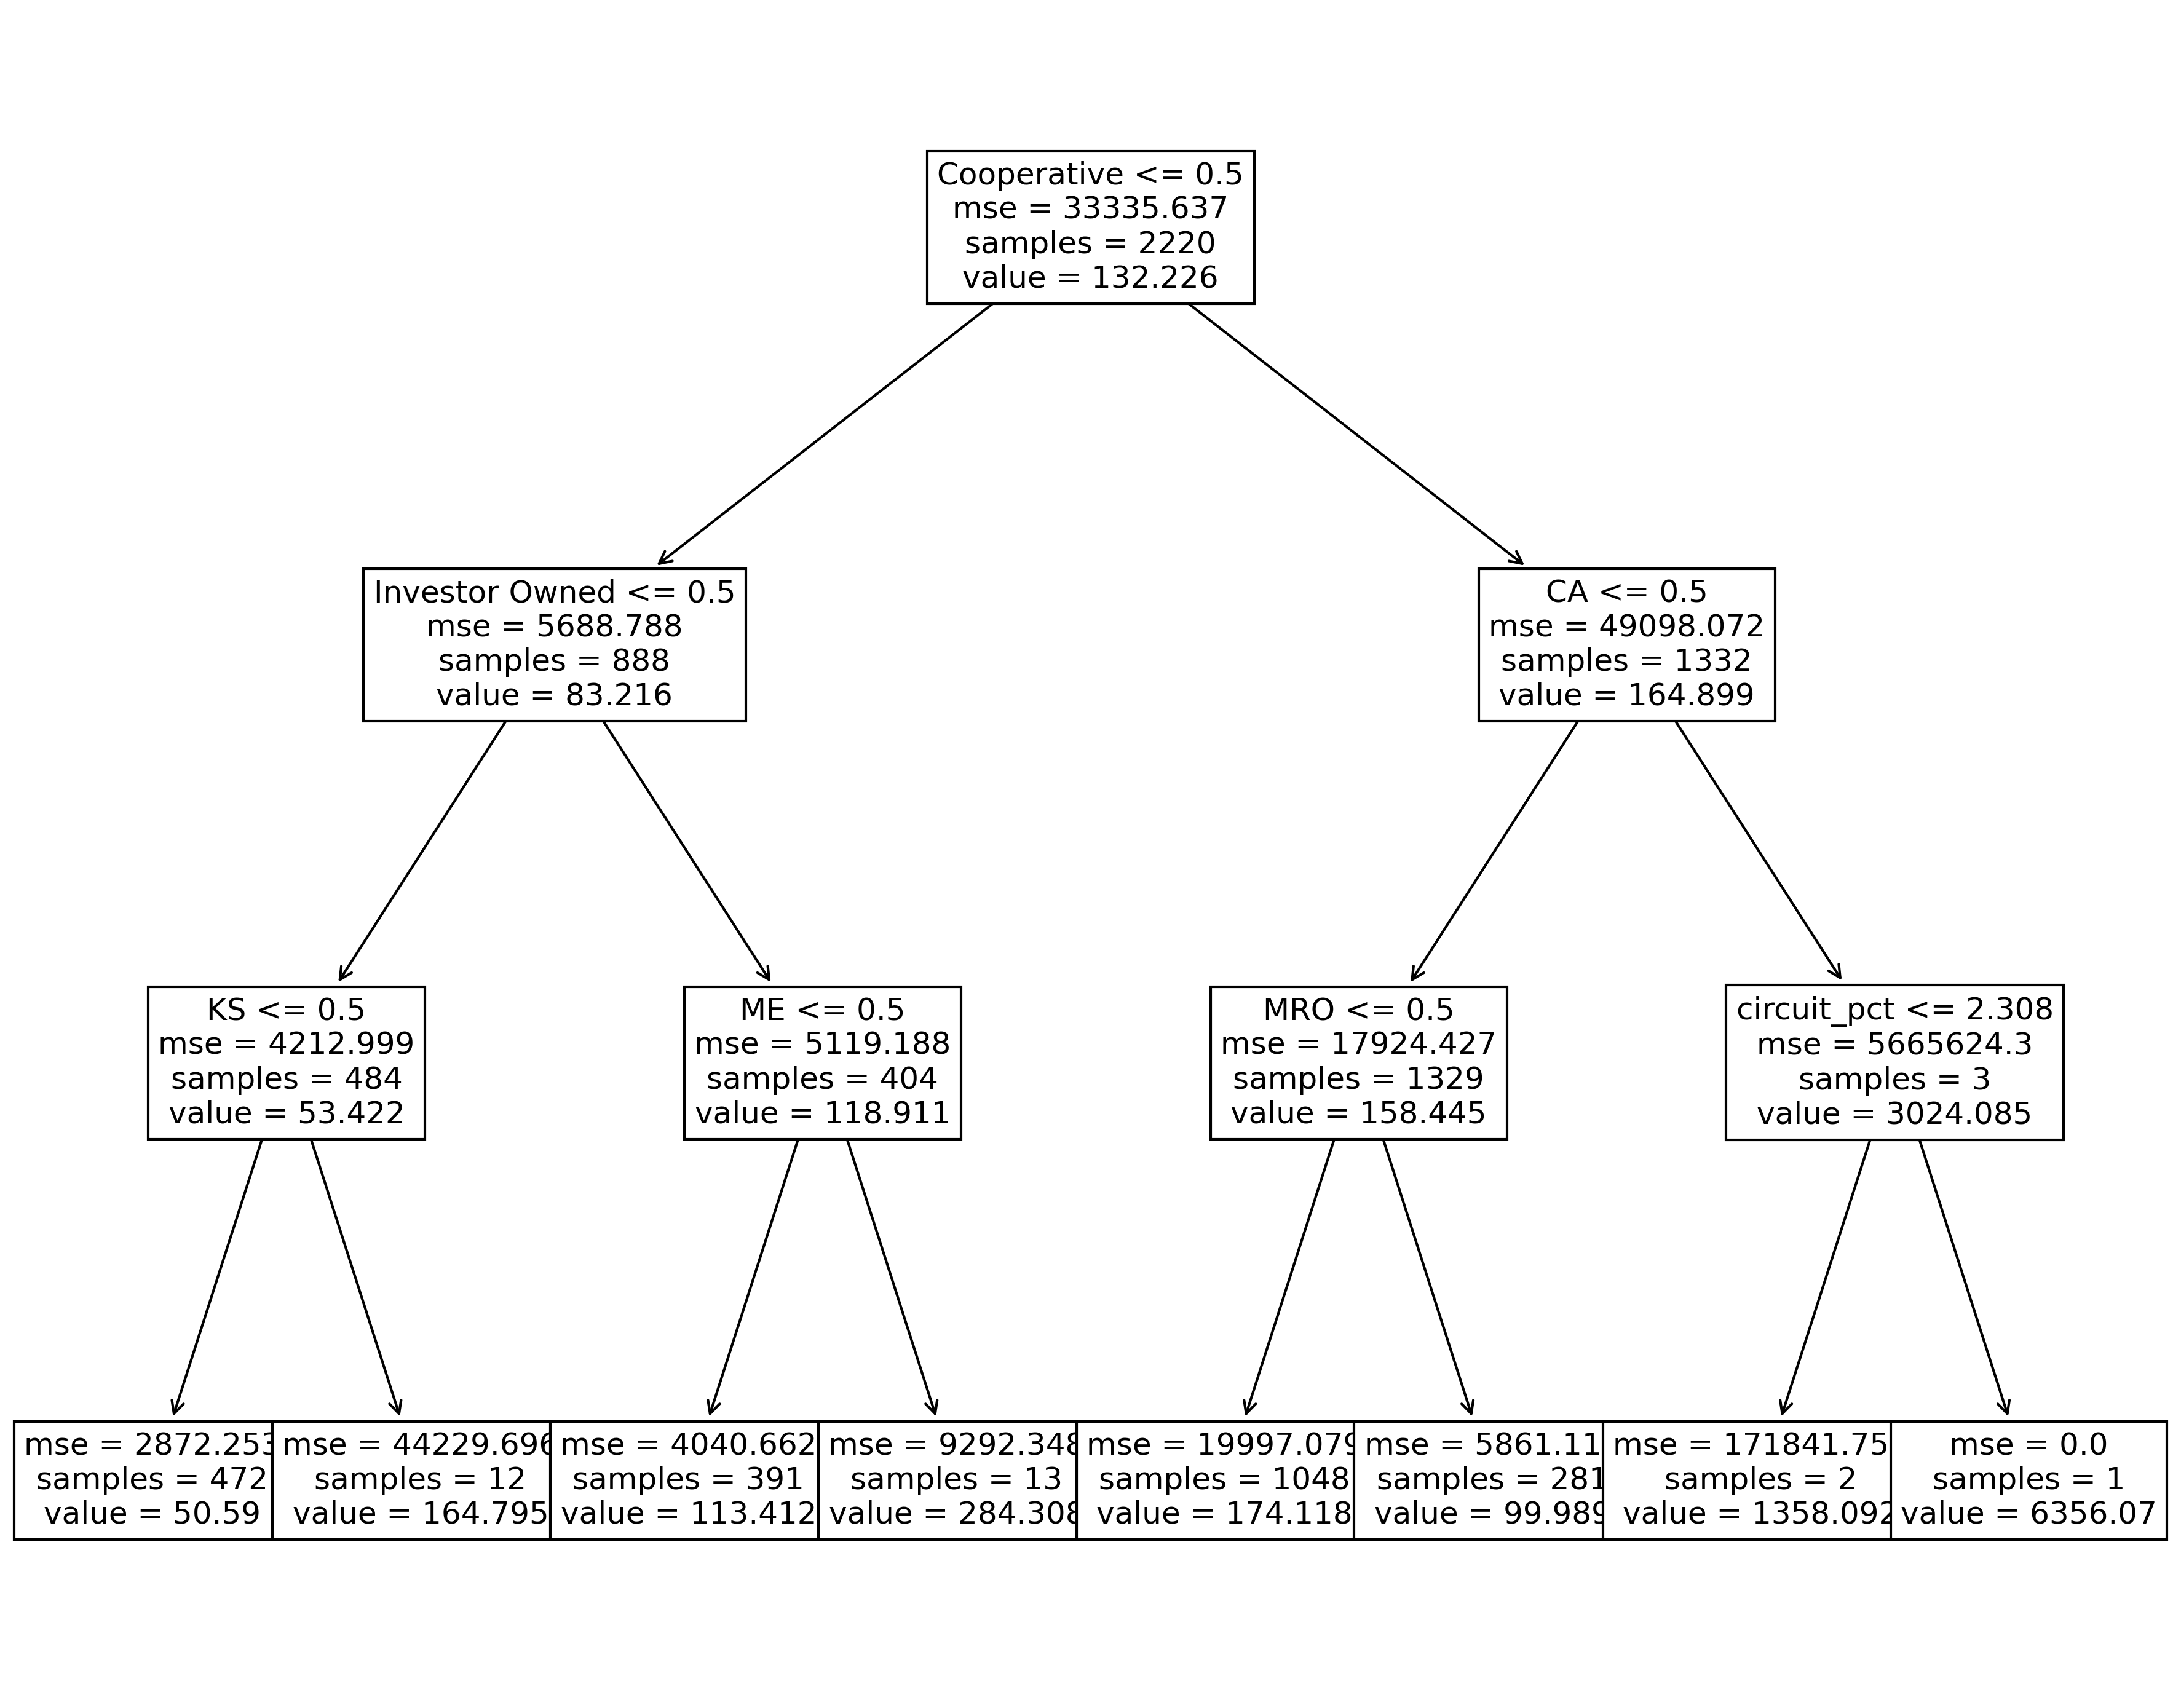

In [46]:
mod = DTree(max_depth=3) # Initialize the modeling object (just as we did)
mod.fit(train_X_log,train_y_log) # Fit the model

# Plot the tree
plt.figure(figsize=(15,12),dpi=300)
rules = tree.plot_tree(mod,feature_names = col_names,fontsize=12)
plt.savefig('experiment_4_decisiontree.png')


### Bagging

In [47]:
bag_scores = cross_validate(Bag(),train_X_log,train_y_log, cv = fold_generator, scoring =use_metrics)

### Random Forest

In [48]:
# takes longer, because 1000 models 
rf_scores = cross_validate(RF(),train_X_log,train_y_log, cv = fold_generator, scoring =use_metrics)

In [49]:
RF().get_params

<bound method BaseEstimator.get_params of RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)>

## Compare models

In [50]:
# Collect all the metrics we care about as a dictionary 
# name them by which method we used
collect_scores = \
dict(lm = lm_scores['test_neg_mean_squared_error']*-1,
     knn = knn_scores['test_neg_mean_squared_error']*-1,
     dt = dt_scores['test_neg_mean_squared_error']*-1,
     bag = bag_scores['test_neg_mean_squared_error']*-1,
     rf = rf_scores['test_neg_mean_squared_error']*-1)

# Convert to a data frame and reshape
collect_scores = pd.DataFrame(collect_scores).melt(var_name="Model",value_name="MSE")
collect_scores

,Model,MSE
0,lm,8258.760598
1,lm,94532.951350
2,lm,13808.624891
3,lm,11581.836049
4,lm,16952.459340
5,knn,9820.854267
6,knn,97135.816318
7,knn,27153.774195
8,knn,9159.932185
9,knn,13313.987754


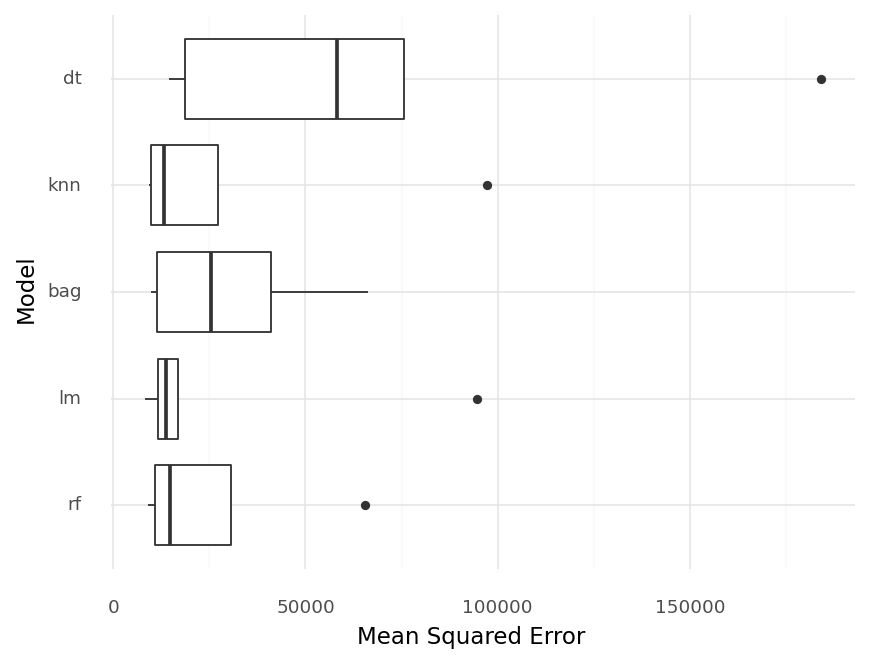

<ggplot: (8777201304305)>

In [51]:
# Get the order of the models
order = (collect_scores.groupby('Model').mean().sort_values(by="MSE").index.tolist())

# Plot
(
    ggplot(collect_scores,
          aes(x="Model",y="MSE")) +
    geom_boxplot() +
    scale_x_discrete(limits=order) +
    labs(x="Model",y="Mean Squared Error") +
    coord_flip() +
    theme_minimal() +
    theme(dpi=150)
)

# Hyperparameter tuning

In [68]:
knn_tune_params = {'n_neighbors':[1,2,3,5,10,20,30]}

In [69]:
tune_knn = GridSearchCV(KNN(),knn_tune_params,
                        cv = fold_generator,
                        scoring='neg_mean_squared_error',
                        n_jobs=4)

In [70]:
tune_knn.fit(train_X_log,train_y_log)

GridSearchCV(cv=KFold(n_splits=5, random_state=111, shuffle=True),
             error_score=nan,
             estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30,
                                           metric='minkowski',
                                           metric_params=None, n_jobs=None,
                                           n_neighbors=5, p=2,
                                           weights='uniform'),
             iid='deprecated', n_jobs=4,
             param_grid={'n_neighbors': [1, 2, 3, 5, 10, 20, 30]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [71]:
tune_knn.best_params_

{'n_neighbors': 20}

In [72]:
tune_knn.best_score_

-29689.912443182373

In [57]:
rf_params = {'n_estimators':[1000,1250], 'max_depth': [30,40], 'max_features': [40,50]} 

tune_rf = GridSearchCV(RF(),rf_params,
                        cv = fold_generator,
                        scoring='neg_mean_squared_error',
                        n_jobs=4, 
                        verbose = 10)

In [59]:
tune_rf.fit(train_X_log,train_y_log)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   33.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   54.1s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  1.8min
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done  38 out of  40 | elapsed:  2.8min remaining:    8.7s
[Parallel(n_jobs=4)]: Done  40 out of  40 | elapsed:  2.8min finished


GridSearchCV(cv=KFold(n_splits=5, random_state=111, shuffle=True),
             error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verb

In [60]:
tune_rf.best_params_

{'max_depth': 40, 'max_features': 40, 'n_estimators': 1000}

In [61]:
tune_rf.best_score_

-22104.778237057268

### RF feature importance

In [62]:
rf = RF(n_estimators=1000, max_features=40, max_depth=40)

In [63]:
rf.fit(train_X_log,train_y_log)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=40, max_features=40, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [64]:
sorted_idx = rf.feature_importances_.argsort()

In [65]:
sorted_idx[-10:]

array([12, 11,  7,  1, 60, 15, 17,  2, 22,  0])

In [66]:
train_X_log.columns[sorted_idx]

Index(['HI', 'HI', 'serc', 'DC', 'DE', 'ND', 'MD', 'NJ', 'RI', 'MA', 'VT',
       'PA', 'NH', 'MS', 'AK', 'AK', 'CT', 'SD', 'AL', 'NV', 'IA', 'WI', 'OK',
       'MISO', 'WV', 'UT', 'SC', 'NE', 'IL', 'MO', 'ECAR', 'MT', 'FL',
       'Political Subdivision', 'MN', 'WY', 'NPCC', 'OR', 'AZ', 'CO', 'KY',
       'LA', 'OH', 'WA', 'MI', 'KS', 'NC', 'NY', 'VA', 'NM', 'IN', 'ME',
       'SERC', 'RFC', 'WECC', 'GA', 'Investor Owned', 'ID', 'TRE', 'SPP',
       'MRO', 'nm_pct', 'TX', 'Cooperative', 'Municipal', 'circuit_pct', 'CA',
       'total_mwh'],
      dtype='object')

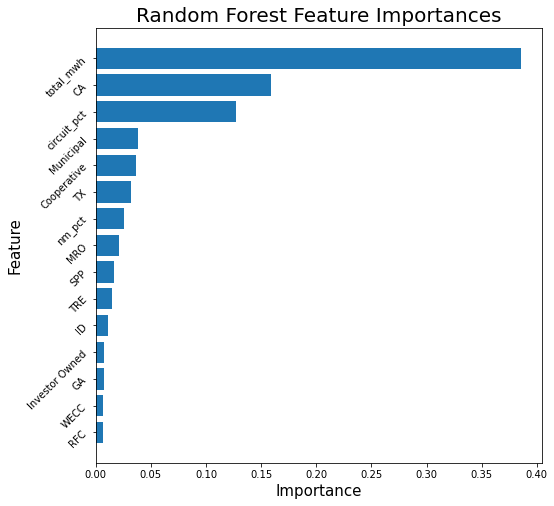

In [67]:
plt.figure(figsize=(8, 8))
plt.title("Random Forest Feature Importances", fontsize=20)
plt.ylabel("Feature", fontsize=15)
plt.yticks(fontsize=10, rotation=45)
plt.xticks(fontsize=10)
plt.xlabel("Importance", fontsize=15)
plt.barh(train_X_log.columns[sorted_idx[-15:]], rf.feature_importances_[sorted_idx[-15:]])
plt.savefig('experiment_4.5_rf_importances.png')

## ML pipeline

In [73]:
preprocess = ColumnTransformer(transformers=[('num', pp.MinMaxScaler(),  make_column_selector(dtype_exclude=None))])

In [74]:
# initialize our pipeline 
pipe = Pipeline(steps=[('pre_process', preprocess),
                       ('model',None)])

In [75]:
search_space = [
    # Linear Model
    {'model' : [LM()]},
    
    # KNN with K tuning param, use double underscore to separate model from its parameter__
    {'model' : [KNN(n_neighbors=20)]},
    
    # Decision Tree with the Max Depth Param
    {'model': [DTree()]},
    
    # The Bagging decision tree model 
    {'model': [Bag()]},
    
    # Random forest with the N Estimators tuning param
    {'model' : [RF(n_estimators = 1000, max_features = 40, max_depth = 40)]
    }
]

In [76]:
# use 10 folds instead of 5
fold_generator_10 = KFold(n_splits=10, shuffle=True,random_state=111)

In [77]:
search = GridSearchCV(pipe, search_space, 
                      cv = fold_generator_10,
                      scoring='neg_mean_squared_error',
                      n_jobs=4,
                      verbose = 10)

In [78]:
search.fit(train_X_log,train_y_log)

Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Batch computation too fast (0.0805s.) Setting batch_size=2.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done  26 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:   39.2s finished


GridSearchCV(cv=KFold(n_splits=10, random_state=111, shuffle=True),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('pre_process',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num',
                                                                         MinMaxScaler(copy=True,
                                                                                      feature_range=(0,
                                                                                                     1)),
                                                                         <sklearn.compose._column_transf

In [79]:
search.best_score_ # Mean out-of-sample (CV) error

-21767.75392077683

In [80]:
train_y_log.describe()

count    2220.000000
mean      132.225736
std       182.621631
min         0.000000
25%        55.865500
50%        96.565000
75%       160.986500
max      6356.070000
Name: saidi_nomed, dtype: float64

In [81]:
search.best_params_

{'model': RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                       max_depth=40, max_features=40, max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=1000, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)}

In [83]:
rf_mod = search.best_estimator_

## Predictions

In [84]:
pred_y_log = search.predict(test_X_log)

In [85]:
m.mean_squared_error(test_y_log,pred_y_log)

21084.557103690742

In [86]:
m.r2_score(test_y_log,pred_y_log)

0.1626746446671029

In [170]:
plot = (
    ggplot(pd.DataFrame(dict(pred=pred_y_log,truth=test_y_log)),
          aes(x='pred',y="truth")) +
    labs(title = 'Model Prediction Accuracy', x = 'Prediction', y = 'Truth') +
    geom_point(alpha=.75) +
    geom_abline(linetype="dashed",color="darkred",size=1) +
    theme_bw() +
    theme(figure_size=(10,7))
)

plot.save('experiment_4.5_accuracy.png', height=6, width=8)

## RF Permutation Importance

In [346]:
# vi = permutation_importance(rf_mod,train_X_log,train_y_log,n_repeats=25)

In [358]:
# # Organize as a data frame 
# vi_dat = pd.DataFrame(dict(variable=train_X_log.columns,
#                            vi = vi['importances_mean'],
#                            std = vi['importances_std']))

# # Generate intervals
# vi_dat['low'] = vi_dat['vi'] - 2*vi_dat['std']
# vi_dat['high'] = vi_dat['vi'] + 2*vi_dat['std']

# # But in order from most to least important

# vi_dat = vi_dat.sort_values(by="vi",ascending=False)[:11].reset_index(drop=True)

# vi_dat

,variable,vi,std,low,high
0,total_mwh,0.493210,0.049296,0.394619,0.591802
1,Municipal,0.195768,0.021900,0.151967,0.239569
2,NC,0.169217,0.021083,0.127051,0.211383
3,ee_pct,0.153067,0.008204,0.136658,0.169475
4,dem_res_cust_pct,0.147573,0.020314,0.106945,0.188201
5,voltage,0.093422,0.007886,0.077650,0.109193
6,nm_pct,0.085707,0.007569,0.070569,0.100845
7,IN,0.076716,0.006893,0.062931,0.090501
8,SERC,0.050458,0.007673,0.035113,0.065803
9,SPP,0.050153,0.006842,0.036469,0.063837


In [363]:
# # Plot

# plot = (
#     ggplot(vi_dat,
#           aes(x="variable",y="vi")) +
#     geom_col(alpha=.5) +
#     geom_point() +
#     geom_errorbar(aes(ymin="low",ymax="high"),width=.2) +
#     theme_bw() +
#     scale_x_discrete(limits=vi_dat.variable.tolist()) +
#     coord_flip() +
#     labs(y="Reduction in MSE",x="", title = "Permutation Feature Importance")
# )

# plot.save('experiment_4_feature_importance.png')